# Import 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass

from matplotlib import pyplot as plt
from snec_to_tardis_parser import parse_snec_to_tardis

from input_profiles import read_snec_isotope_profile
from xg_files import read_xg_file
from read_snec_output import read_snec_output
from tardis_utils import run_tardis_from_yml
from tqdm.notebook import tqdm
from scipy import interpolate
from astropy import units as u, constants as const
from radioactivedecay.utils import Z_DICT

from tardis_utils import write_tardis_csvy, write_tardis_config
import xarray as xr
import yaml

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SNEC_FOLDER_PATH = Path(
    "/Users/wkerzend/projects/tardis/connector/models/MESA_STIR_MESA_SNEC"
)
TARDIS_EXAMPLE_CONFIG_FOLDER_PATH = Path.cwd() / "TARDIS_template_configs"


# Convert SNEC to TARDIS configs 

In [4]:
input_isotope_fraction = read_snec_isotope_profile(
    SNEC_FOLDER_PATH / "input" / "profile8.data.iso.dat"
)

In [5]:
input_isotope_fraction_da = input_isotope_fraction.to_xr_array()

In [6]:
snec_output = read_snec_output(SNEC_FOLDER_PATH)

In [7]:
# Build the full dataset using the SNECOutput helper
snec_output_ds = snec_output.to_xr_dataset()

In [9]:
snec_output_ds.enclosed_mass

<xarray.DataArray 'enclosed_mass' (cell_id: 1138)> Size: 9kB
array([3.33171076e+33, 3.33691777e+33, 3.34212477e+33, ...,
       9.24166135e+33, 9.24686835e+33, 9.25207536e+33])
Coordinates:
  * cell_id        (cell_id) int64 9kB 1 2 3 4 5 6 ... 1134 1135 1136 1137 1138
    enclosed_mass  (cell_id) float64 9kB 3.332e+33 3.337e+33 ... 9.252e+33

In [10]:
enclosed_mass_snec = snec_output_ds.enclosed_mass.values
interpolated_isotope_fraction = interpolate.interp1d(
    input_isotope_fraction.enclosed_mass,
    input_isotope_fraction.isotope_mass_fraction.values.T,
    bounds_error=False,
    fill_value=np.nan,
)(enclosed_mass_snec)

interpolated_isotope_fraction_df = pd.DataFrame(
    data=interpolated_isotope_fraction,
    index=input_isotope_fraction.isotope_mass_fraction.columns,
)

# Removing Neutron Fraction
interpolated_isotope_fraction_df.drop([(0, 1)], axis=0, inplace=True)

# Normalizing the isotope fractions
interpolated_isotope_fraction_df = (
    interpolated_isotope_fraction_df / interpolated_isotope_fraction_df.sum(axis=0)
)

In [11]:
interpolated_isotope_fraction_df

,,0,1,2,3,4,5,6,7,8,9,...,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137
element_number,mass_number,,,,,,,,,,,,,,,,,,,,,
1,1,NaN,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,7.624854e-17,7.624854e-17,7.624854e-17,7.624854e-17,7.624854e-17,7.624854e-17,7.624854e-17,7.624854e-17,7.624854e-17,7.624854e-17
2,4,NaN,0.041651,0.046446,0.047870,0.048459,0.048686,0.048788,0.048823,0.048784,0.048671,...,9.805764e-01,9.805764e-01,9.805764e-01,9.805764e-01,9.805764e-01,9.805764e-01,9.805764e-01,9.805764e-01,9.805764e-01,9.805764e-01
6,12,NaN,0.000216,0.000228,0.000238,0.000252,0.000266,0.000283,0.000298,0.000313,0.000331,...,1.305093e-02,1.305093e-02,1.305093e-02,1.305093e-02,1.305093e-02,1.305093e-02,1.305093e-02,1.305093e-02,1.305093e-02,1.305093e-02
8,16,NaN,0.125693,0.146447,0.155395,0.162285,0.167921,0.173418,0.177991,0.182282,0.186411,...,2.422768e-04,2.422768e-04,2.422768e-04,2.422768e-04,2.422768e-04,2.422768e-04,2.422768e-04,2.422768e-04,2.422768e-04,2.422768e-04
10,20,NaN,0.065865,0.046228,0.038900,0.034757,0.031932,0.029693,0.027949,0.026554,0.025482,...,2.098416e-03,2.098416e-03,2.098416e-03,2.098416e-03,2.098416e-03,2.098416e-03,2.098416e-03,2.098416e-03,2.098416e-03,2.098416e-03
12,24,NaN,0.025203,0.023226,0.023187,0.023568,0.024049,0.024666,0.025212,0.025785,0.026408,...,4.031706e-03,4.031706e-03,4.031706e-03,4.031706e-03,4.031706e-03,4.031706e-03,4.031706e-03,4.031706e-03,4.031706e-03,4.031706e-03
14,28,NaN,0.194553,0.193964,0.193904,0.193940,0.193987,0.194045,0.194077,0.194098,0.194103,...,3.052944e-07,3.052944e-07,3.052944e-07,3.052944e-07,3.052944e-07,3.052944e-07,3.052944e-07,3.052944e-07,3.052944e-07,3.052944e-07
16,32,NaN,0.096014,0.095527,0.095170,0.094730,0.094311,0.093835,0.093427,0.093014,0.092581,...,5.065812e-09,5.065812e-09,5.065812e-09,5.065812e-09,5.065812e-09,5.065812e-09,5.065812e-09,5.065812e-09,5.065812e-09,5.065812e-09
18,36,NaN,0.020616,0.020520,0.020434,0.020324,0.020219,0.020099,0.019996,0.019892,0.019784,...,2.561031e-10,2.561031e-10,2.561031e-10,2.561031e-10,2.561031e-10,2.561031e-10,2.561031e-10,2.561031e-10,2.561031e-10,2.561031e-10


In [12]:
# Drop the first time step and the innermost cell
snec_output_ds = snec_output_ds.isel(time=slice(1, None), cell_id=slice(0, None))

# Explorational Plotting

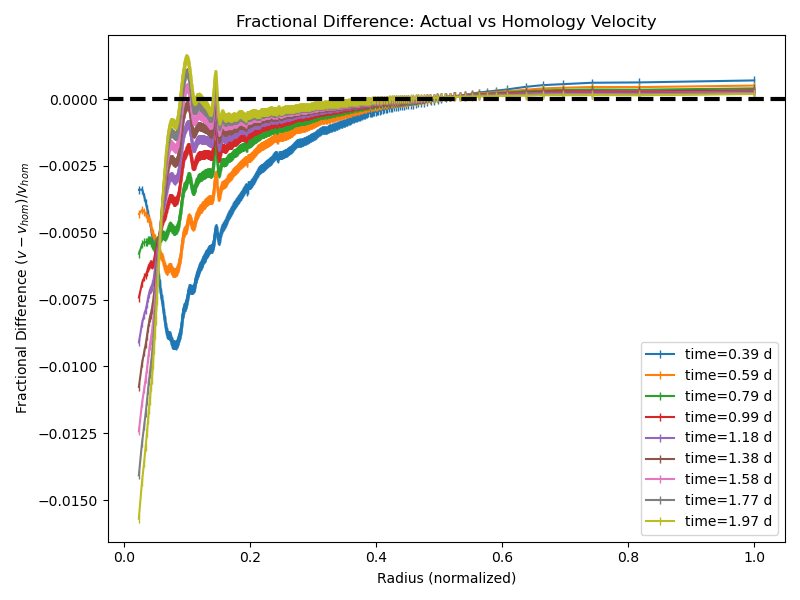

In [13]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(8, 6))
vel = snec_output_ds.vel
radius = snec_output_ds.radius
for requested_t_idx in range(1, 10):
    radius_au = (radius.isel(time=requested_t_idx).values * u.cm).to(u.AU)[1:]
    vel_kms = (vel.isel(time=requested_t_idx).values * u.cm / u.s).to(u.km / u.s)[1:]
    current_time = snec_output_ds.time.values[requested_t_idx] * u.s
    homology_kms = (radius_au / current_time).to(u.km / u.s)

    ax.plot(
        radius_au.value / radius_au.max(),
        ((vel_kms - homology_kms) / homology_kms).to(1).value,
        label=f"time={current_time.to(u.day):.2f}",
        marker="|",
    )
ax.axhline(0, color="black", linestyle="--", lw=3)
ax.set_xlabel("Radius (normalized)")
ax.set_ylabel("Fractional Difference $(v - v_{hom})/v_{hom}$")
ax.set_title("Fractional Difference: Actual vs Homology Velocity")
ax.legend()
plt.tight_layout()
plt.show()
plt.savefig("homology_reached.pdf")


Text(0.5, 1.0, 'Photosphere Velocity Evolution')

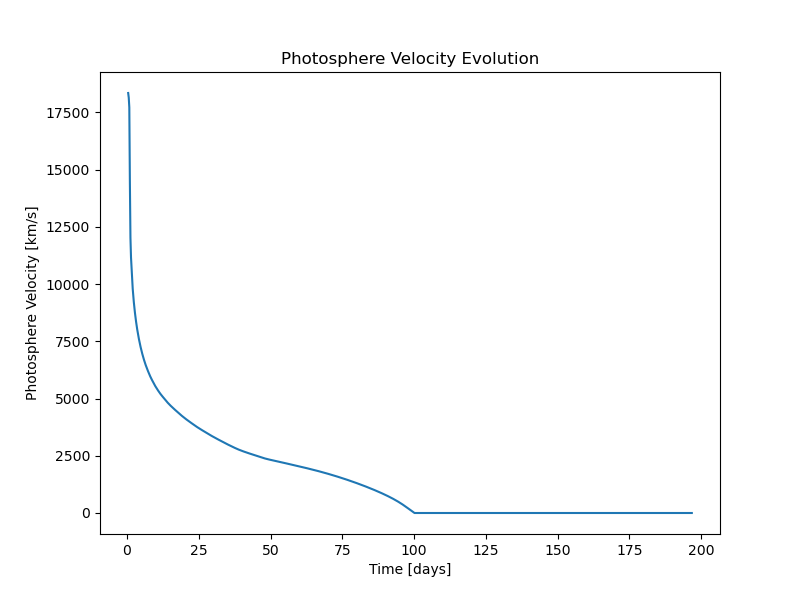

In [14]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    (snec_output_ds.time.values[1:] * u.s).to(u.day),
    (snec_output_ds.vel_photo.values * (u.cm / u.s)).to(u.km / u.s)[1:],
)  # km/s
ax.set_xlabel("Time [days]")
ax.set_ylabel("Photosphere Velocity [km/s]")
ax.set_title("Photosphere Velocity Evolution")

# Setting photospheric phase 

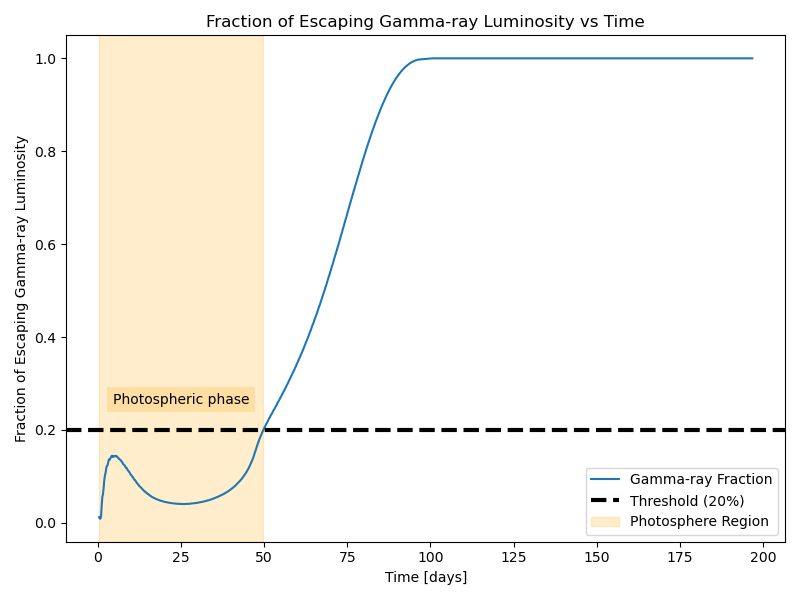

In [15]:
%matplotlib widget

GAMMA_RAY_ESCAPE_THRESHOLD = 0.2  # used in Lu et al. 2024

fig, ax = plt.subplots(figsize=(8, 6))
fraction_gamma_ray = (
    snec_output_ds.lum_observed.values[1:] - snec_output_ds.lum_photo.values[1:]
) / snec_output_ds.lum_observed.values[1:]
time_days = (snec_output_ds.time.values[1:] * u.s).to(u.day).value
ax.plot(time_days, fraction_gamma_ray, label="Gamma-ray Fraction")

ax.axhline(
    GAMMA_RAY_ESCAPE_THRESHOLD,
    color="black",
    linestyle="--",
    lw=3,
    label="Threshold (20%)",
)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Fraction of Escaping Gamma-ray Luminosity")
ax.set_title("Fraction of Escaping Gamma-ray Luminosity vs Time")

PHOTOSPHERE_START_INDEX = 1
PHOTOSPHERE_END_INDEX = np.abs(fraction_gamma_ray - GAMMA_RAY_ESCAPE_THRESHOLD).argmin()

# Calculate photosphere times in days
photosphere_start_day = (
    (snec_output_ds.time.values[PHOTOSPHERE_START_INDEX] * u.s).to(u.day).value
)
photosphere_end_day = (
    (snec_output_ds.time.values[PHOTOSPHERE_END_INDEX] * u.s).to(u.day).value
)

# Shade the photosphere region with axvspan
ax.axvspan(
    photosphere_start_day,
    photosphere_end_day,
    color="orange",
    alpha=0.2,
    label="Photosphere Region",
)

# Add a textbox in the middle of the shaded region
midpoint = (photosphere_start_day + photosphere_end_day) / 2
ax.text(
    midpoint,
    GAMMA_RAY_ESCAPE_THRESHOLD + 0.05,
    "Photospheric phase",
    ha="center",
    va="bottom",
    fontsize=10,
    bbox=dict(facecolor="orange", alpha=0.2, edgecolor="none"),
)

ax.legend()
plt.tight_layout()
plt.show()
plt.savefig("plots/gamma_ray_escape_photosphere.pdf")


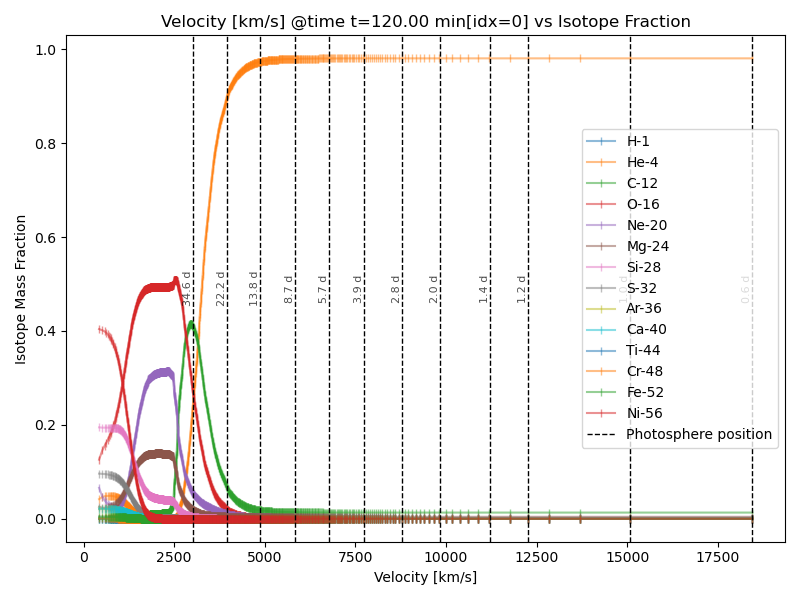

In [17]:
%matplotlib widget

# Find the index in time_days closest to requested_time
requested_time = 120 * u.min
requested_t_idx = np.abs(time_days - requested_time.to(u.day).value).argmin()
x_axis_type = "vel"

if x_axis_type != "vel":
    raise ValueError("does not work - fix the Unit Conversion")
# Get the x-axis (enclosed mass) from the second time index onwards (skip time=0)
x_axis = snec_output_ds[x_axis_type].isel(time=requested_t_idx).values

if x_axis_type == "vel":
    x_axis = (x_axis * u.cm / u.s).to(u.km / u.s).value
    x_axis_label = "Velocity [km/s]"

if x_axis_type == "mass":
    x_axis = (x_axis * u.g).to(u.Msun).value
    x_axis_label = "Enclosed Mass [Msun]"

if x_axis_type == "radius":
    x_axis = (x_axis * u.cm).to(u.Rsun).value
    x_axis_label = "Radius [Rsun]"


# Convert the multi_index of interpolated_isotope_fraction_df to isotope names
df_iso = interpolated_isotope_fraction_df.copy()
df_iso.index = [f"{Z_DICT.get(z, z)}-{mass}" for z, mass in df_iso.index]
plt.clf()
fig, ax = plt.subplots(figsize=(8, 6))
for isotope in df_iso.index:
    fraction = df_iso.loc[isotope]
    ax.plot(x_axis, fraction, label=f"{isotope}", alpha=0.5, marker="|")

photo_location_last = 1e99
# Add photosphere positions as vertical lines with time labels

no_label = True
x_axis_span = x_axis.max() - x_axis.min()
for idx in range(PHOTOSPHERE_START_INDEX + 1, PHOTOSPHERE_END_INDEX + 1):
    snec_time_slice = snec_output_ds.isel(time=idx)
    photosphere_index = int(snec_time_slice.index_photo.values)
    photosphere_location = (
        (
            snec_time_slice.sel(cell_id=photosphere_index)[x_axis_type].values
            * u.cm
            / u.s
        )
        .to(u.km / u.s)
        .value
    )
    t_day = (snec_time_slice.time.values * u.s).to(u.day)
    if np.abs(photo_location_last - photosphere_location) < (x_axis_span / 20):
        continue

    # Find the cell where velocity is closest to v_photo at time=0
    vel0_kms = (vel.isel(time=0).values[1:] * u.cm / u.s).to(u.km / u.s).value

    ax.axvline(
        photosphere_location,
        color="black",
        linestyle="--",
        label="Photosphere position" if no_label else "",
        lw=1,
    )
    no_label = False
    ax.text(
        photosphere_location,
        0.5,
        f"{t_day:.1f}",
        rotation=90,
        color="black",
        va="center",
        ha="right",
        fontsize=8,
        alpha=0.7,
        transform=ax.get_xaxis_transform(),
    )
    photo_location_last = photosphere_location

ax.set_xlabel(x_axis_label)
ax.set_ylabel("Isotope Mass Fraction")
ax.set_title(
    f"{x_axis_label} @time t={requested_time:.2f}[idx={requested_t_idx}] vs Isotope Fraction"
)
ax.legend()
plt.tight_layout()
plt.show()
# plt.semilogy()
# plt.savefig("plots/isotope_fraction_photosphere_enclosed_mass.pdf")


# Write TARDIS Configurations

In [18]:
# Parameters (tweak as needed)
tau_lower_limit = 1e-1
# tau_lower_limit = 1e-2
tau_upper_limit = 50
num_keep_shells = 45

# Paths to templates and output folder
# (These were already defined in a previous cell: tardis_csvy_template, tardis_config_template, SNEC_FOLDER_PATH, TARDIS_EXAMPLE_CONFIG_FOLDER_PATH)
output_dir = SNEC_FOLDER_PATH / "tardis_configs"
output_dir.mkdir(exist_ok=True, parents=True)

requested_time_explosion = [10, 20, 40] * u.day


interp_time_snec_output_ds = snec_output_ds.interp(
    time=requested_time_explosion.to(u.s).value, method="linear"
)
TARDIS_ISOTOPE_COLUMN_NAMES = [
    f"{Z_DICT.get(int(item.element_number))}{int(item.mass_number)}"
    for item in snec_output_ds.isotope
]
tardis_isotope_profile = (
    snec_output_ds.isotope_mass_fraction.to_dataframe()["isotope_mass_fraction"]
    .unstack(level=0)
    .T
)

tardis_isotope_profile.columns = TARDIS_ISOTOPE_COLUMN_NAMES

AttributeError: 'Dataset' object has no attribute 'isotope'

In [19]:

TARDIS_TEMPLATE_CONFIG = yaml.safe_load(
    open(TARDIS_EXAMPLE_CONFIG_FOLDER_PATH / "tardis_template_config_SESN.yml", "r")
)
TARDIS_FILE_PREFIX = "tardis_connector_snec"
MODEL_NAME = "MESA_STIR_MESA_SNECv1"
TARDIS_SELECTED_QUANTITIES = ["vel", "rho", "temp", "tau"]
CSVY_HEADER = """\
---
name: {TARDIS_FILE_PREFIX}
model_density_time_0: {model_density_day:.2f}
model_isotope_time_0: 0 day
description: Example csvy config file for TARDIS.
tardis_model_config_version: v1.0
v_inner_boundary: {v_inner_boundary:.6e}
datatype:
  fields:
    -  name: velocity
       unit: km/s
       desc: velocities of shell outer boundaries.
    -  name: density
       unit: g/cm^3
       desc: density of shell.
    -  name: t_rad
       unit: K
       desc: radiative temperature."""

ISOTOPE_ABUNDANCES_HEADER = """
    -  name: {iso}
       desc: fractional {iso} abundance."""

TARDIS_OUTPUT_BASE = Path.cwd() / "tardis_output"

for requested_time_idx in range(len(requested_time_explosion)):
    current_time_explosion = requested_time_explosion[requested_time_idx]
    current_snec_output = interp_time_snec_output_ds.isel(time=requested_time_idx)
    
    current_tardis_slice = current_snec_output[TARDIS_SELECTED_QUANTITIES]

    tardis_model_df = current_tardis_slice.to_dataframe()[TARDIS_SELECTED_QUANTITIES]
    tardis_model_df.rename({"vel": "velocity", "rho": "density", "temp": "t_rad"}, axis=1, inplace=True)
    tardis_model_df['velocity'] = (tardis_model_df['velocity'].values * u.cm / u.s).to(u.km / u.s).value
    tardis_model_df.join(tardis_isotope_profile)
    
    tau_mask = (
        (tardis_model_df["tau"] > tau_lower_limit)
        & (tardis_model_df["tau"] < tau_upper_limit)
    )

    tardis_model_df = tardis_model_df[tau_mask]
    tardis_model_df = tardis_model_df.join(tardis_isotope_profile)
    shell_gap_length = max(
        [int(np.floor(tardis_model_df.shape[0] / num_keep_shells)), 1]
    )

    tardis_small_model_df = tardis_model_df.groupby(
        np.arange(len(tardis_model_df)) // shell_gap_length
    ).mean()
    

    tardis_small_model_df.drop(columns=["tau"], inplace=True)
    #v_inner_boundary = (current_snec_output.sel(cell_id=int(current_snec_output.index_photo)).vel.values * u.cm / u.s).to(u.km / u.s)
    v_inner_boundary = tardis_small_model_df.velocity.iloc[0] * u.km / u.s
    
    new_csvy_header = CSVY_HEADER.format(
        TARDIS_FILE_PREFIX=TARDIS_FILE_PREFIX,
        model_density_day=requested_time_explosion[requested_time_idx].to(u.day),
        v_inner_boundary=v_inner_boundary,
    )
    for iso in tardis_small_model_df.columns[3:]:
        new_csvy_header += ISOTOPE_ABUNDANCES_HEADER.format(iso=iso)
    new_csvy_header += "\n---\n"

    tardis_model_dir = TARDIS_OUTPUT_BASE / MODEL_NAME
    tardis_model_dir.mkdir(exist_ok=True)

    tardis_model_fname = f"{TARDIS_FILE_PREFIX}_{current_time_explosion.to(u.day):.1f}d_normal_atom"
    with open(
        tardis_model_dir / f"{tardis_model_fname}.csvy",
        "w",
    ) as fh:
        fh.write(new_csvy_header)
        tardis_small_model_df.to_csv(
            fh,
            header=True,
            index=False,
        )
    tardis_config = TARDIS_TEMPLATE_CONFIG.copy()
    tardis_config["csvy_model"] = f"{tardis_model_fname}.csvy"
    tardis_config["supernova"]["time_explosion"] = f"{current_time_explosion:.2f}"
    tardis_config["supernova"]["luminosity_requested"] = f"{current_snec_output.lum_observed.values * u.erg/u.s}"
    tardis_config["plasma"]["initial_t_inner"] = f"{current_snec_output.T_eff.values * u.K}"

    with open(
        tardis_model_dir / f"{tardis_model_fname}.yml",
        "w",
    ) as fh:
        yaml.dump(tardis_config, fh, default_flow_style=False, sort_keys=False, indent=4)
    print(f"Created TARDIS config: {tardis_model_dir / f'{tardis_model_fname}.yml'}")

NameError: name 'tardis_isotope_profile' is not defined

# Run tardis simulations and save each spectrum

In [ ]:
# Two arguments are config model path and output file name
from tardis.workflows.v_inner_solver import InnerVelocitySolverWorkflow
from tardis.io.configuration.config_reader import Configuration
from pathlib import Path

tardis_configurations = [list(tardis_model_dir.glob("*.yml"))[0]]
#tardis_configurations = ["/Users/wkerzend/projects/tardis/connector/connector25_github/tardis-connector/example_stir_explosion/tardis_configs/example_stir_explosion_tardis_config_1.0_day.yml"]
for fname in tardis_configurations:
    print(f"Working on configuration {fname}")
    config = Configuration.from_yaml(fname)
    workflow = InnerVelocitySolverWorkflow(
        config, tau=2.0 / 3, mean_optical_depth="rosseland", csvy=True
    )
    workflow.run()
    spectrum = workflow.spectrum_solver.spectrum_real_packets
    spectrum.to_hdf(fname.with_suffix(".h5"))


Working on configuration /Users/wkerzend/projects/tardis/connector/connector25_github/tardis-connector/tardis_output/MESA_STIR_MESA_SNECv1/tardis_connector_snec_10.0 dd_normal_atom.yml


BokehModel(combine_events=True, render_bundle={'docs_json': {'a3c83929-f8d5-422d-b74b-b943d5b1985f': {'version…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

In [ ]:
import glob
from pathlib import Path
from tardis_utils import run_tardis_from_yml

SNEC_FOLDER_PATH = Path.cwd() / "example_stir_explosion"

tardis_yml_files = sorted(glob.glob(f"{SNEC_FOLDER_PATH}/tardis_configs/*.yml"))
tardis_output_folder_path = SNEC_FOLDER_PATH / "tardis_output"
tardis_output_folder_path.mkdir(exist_ok=True)

for yml_file in tardis_yml_files:
    spec_output_file = (
        tardis_output_folder_path
        / f"{yml_file.split('/')[-1].split('.')[0]}_spectrum.csv"
    )
    run_tardis_from_yml(yml_file, spec_output_file, n_threads=8)

BokehModel(combine_events=True, render_bundle={'docs_json': {'5bbdf2ee-27a8-441d-83d1-fd2b70a451cd': {'version…

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


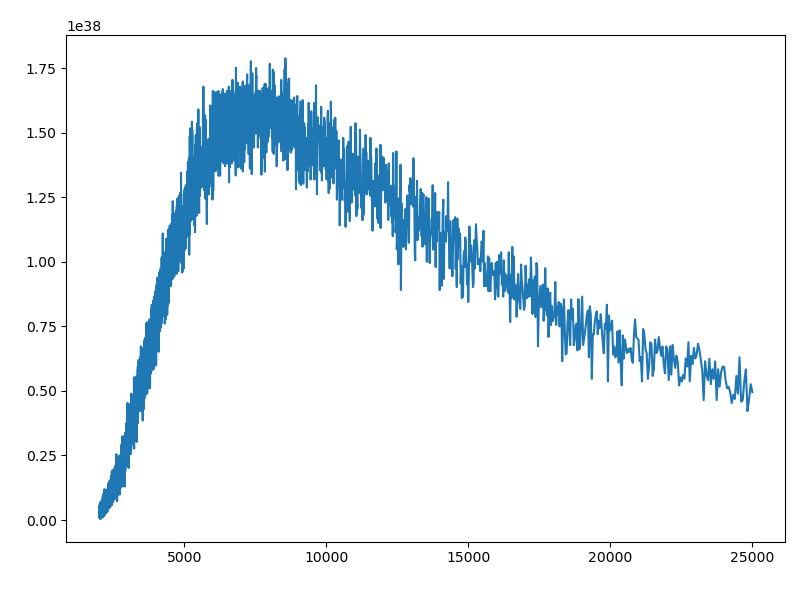

In [ ]:
%pylab widget
clf()
plot(workflow.spectrum_solver.spectrum_real_packets.wavelength, workflow.spectrum_solver.montecarlo_emitted_luminosity)
plt.show()

In [ ]:
workflow.spectrum_solver.montecarlo_emitted_luminosity

<Quantity [4.95137974e+37, 5.26261581e+37, 4.68413247e+37, ...,
           4.18099988e+36, 3.63462662e+36, 2.09135699e+36] erg / s>